#### Create data set

Scan all news directories and read all '.txt' files.

In [1]:
import os
import re
import warnings
import pandas as pd

# HIDE WARNINGS
warnings.filterwarnings("ignore")

# create_directory: CREATES A DIRECTORY IF IT DOES NOT EXIST
def create_directory(directory_name):
    if not os.path.exists(directory_name):
        os.mkdir(directory_name)

path = "./news_data"
ids = list()
titles = list()
contents = list()
categories = list()
# FOR ALL DIRECTORIES
for directory in os.listdir(path):
    if os.path.isdir(f"{path}/{directory}/"):
        # FOR FILES IN EACH DIRECTORY
        for file in os.listdir(f"{path}/{directory}/"):
            if file.endswith(".txt"):
                ids.append(len(ids)+1)
                f = open(f"{path}/{directory}/{file}")
                lines = f.readlines()
                titles.append(lines[0])
                content = ""
                for line in lines[1:]:
                    content = content + " " + line
                contents.append(content)
                categories.append(directory)
# CREATE DATAFRAME
data_set = pd.DataFrame(columns=["id","title","content","category"])
data_set["id"] = ids
data_set["title"] = titles
data_set["content"] = contents
data_set["category"] = categories
# ASSOCIATE CATEGORY NAMES WITH NUMERICAL INDEX
data_set["category_id"] = data_set["category"].factorize()[0]
display(data_set.head(5))
create_directory("./data_sets")
# CREATE data_set.tsv
data_set.to_csv("./data_sets/data_set.tsv",sep="\t",index=False)

,id,title,content,category,category_id
0,1,Ad sales boost Time Warner profit\n,\n Quarterly profits at US media giant TimeWa...,business,0
1,2,Dollar gains on Greenspan speech\n,\n The dollar has hit its highest level again...,business,0
2,3,Yukos unit buyer faces loan claim\n,\n The owners of embattled Russian oil giant ...,business,0
3,4,High fuel prices hit BA's profits\n,\n British Airways has blamed high fuel price...,business,0
4,5,Pernod takeover talk lifts Domecq\n,\n Shares in UK drinks and food firm Allied D...,business,0


#### Display five random samples

In [2]:
data_set.sample(5, random_state=0)

,id,title,content,category,category_id
384,385,Tate & Lyle boss bags top award\n,\n Tate & Lyle's chief executive has been nam...,business,0
1983,1984,Halo 2 sells five million copies\n,\n Microsoft is celebrating bumper sales of i...,tech,4
985,986,MSPs hear renewed climate warning\n,\n Climate change could be completely out of ...,politics,2
1386,1387,Pavey focuses on indoor success\n,\n Jo Pavey will miss January's View From Gre...,sport,3
1294,1295,Tories reject rethink on axed MP\n,\n Sacked MP Howard Flight's local Conservati...,politics,2


#### Distribution of each category

In [3]:
import matplotlib.pyplot as plt
display(data_set.groupby("category").category_id.count())
display(data_set.groupby("category").category_id.count().plot.bar(ylim=0))

category
business         510
entertainment    386
politics         417
sport            511
tech             401
Name: category_id, dtype: int64

#### Create train set and test set

Split data set and create train and test set.

In [4]:
X = data_set.iloc[:,:-1].values
y = data_set.iloc[:,-1].values

# SPLIT DATA SET
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# CREATE TRAIN DATAFRAME
train_set = pd.DataFrame(X_train,columns=["id","title","content","category"])
train_set["category_id"] = pd.DataFrame(y_train,columns=["category_id"])
#display(train_set)
# CREATE TEST DATAFRAME
test_set = pd.DataFrame(X_test,columns=["id","title","content","category"])
test_set["category_id"] = pd.DataFrame(y_test,columns=["category_id"])
#display(test_set)

# MAKE SURE THAT TRAIN SET AND TEST SET HAVE A GOOD SPLIT
# DISPLAY NUMBER OF CATEGORIES FOR TRAIN SET
train_category = train_set.groupby("category").id.count()
train_category = train_category.reset_index()
train_category = train_category.rename(columns={"id":"number_of_categories"})
display(train_category.shape,train_category)
# DISPLAY NUMBER OF CATEGORIES FOR TEST SET
test_category = test_set.groupby("category").id.count()
test_category = test_category.reset_index()
test_category = test_category.rename(columns={"id":"number_of_categories"})
display(test_category.shape,test_category)
# CREATE train_set.tsv AND test_set.tsv
train_set.to_csv("./data_sets/train_set.tsv",sep="\t",index=False,columns=["id","title","content","category"])
test_set.to_csv("./data_sets/test_set.tsv",sep="\t",index=False,columns=["id","title","content"])

(5, 2)

,category,number_of_categories
0,business,399
1,entertainment,312
2,politics,331
3,sport,403
4,tech,335


(5, 2)

,category,number_of_categories
0,business,111
1,entertainment,74
2,politics,86
3,sport,108
4,tech,66


## Preprocessing

First of all read data, train and test set from the disk and save them into three panda dataframes. Also, associate category names with numerical index.

In [5]:
# READ DATASETS
data_set  = pd.read_csv("./data_sets/data_set.tsv", delimiter="\t",names=["id","title","content","category","category_id"],header=0)
train_set = pd.read_csv("./data_sets/train_set.tsv",delimiter="\t",names=["id","title","content","category"],header=0)
test_set  = pd.read_csv("./data_sets/test_set.tsv", delimiter="\t",names=["id","title","content"],           header=0)

# DISPLAY DATAFRAMES
display(data_set.shape,data_set.head(5))
display(train_set.shape,train_set.head(5))
display(test_set.shape,test_set.head(5))

(2225, 5)

,id,title,content,category,category_id
0,1,Ad sales boost Time Warner profit\n,\n Quarterly profits at US media giant TimeWa...,business,0
1,2,Dollar gains on Greenspan speech\n,\n The dollar has hit its highest level again...,business,0
2,3,Yukos unit buyer faces loan claim\n,\n The owners of embattled Russian oil giant ...,business,0
3,4,High fuel prices hit BA's profits\n,\n British Airways has blamed high fuel price...,business,0
4,5,Pernod takeover talk lifts Domecq\n,\n Shares in UK drinks and food firm Allied D...,business,0


(1780, 4)

,id,title,content,category
0,842,Incredibles win animation awards\n,\n The Incredibles movie has beaten Shrek 2 t...,entertainment
1,1749,Hantuchova in Dubai last eight\n,\n Daniela Hantuchova moved into the quarter-...,sport
2,2119,More power to the people says HP\n,\n The digital revolution is focused on letti...,tech
3,1175,Amnesty chief laments war failure\n,\n The lack of public outrage about the war o...,politics
4,1503,SA return to Mauritius\n,\n Top seeds South Africa return to the scene...,sport


(445, 3)

,id,title,content
0,385,Tate & Lyle boss bags top award\n,\n Tate & Lyle's chief executive has been nam...
1,1984,Halo 2 sells five million copies\n,\n Microsoft is celebrating bumper sales of i...
2,986,MSPs hear renewed climate warning\n,\n Climate change could be completely out of ...
3,1387,Pavey focuses on indoor success\n,\n Jo Pavey will miss January's View From Gre...
4,1295,Tories reject rethink on axed MP\n,\n Sacked MP Howard Flight's local Conservati...


#### Clean the data

Remove special characters, replace white spaces to one space, covert text into lower case and remove stop words

In [6]:
from collections import Counter
from nltk.corpus import stopwords

# clean_text: REMOVES SPECIAL CHARACTERS, REPLACE WHITE SPACES TO ONE SPACE, COVERTS TEXT INTO LOWER CASE
def clean_text(text):
    # REMOVE SPECIAL CHARACTERS
    text = re.sub("[^a-zA-z\s]","",text) 
    text = re.sub("_", "", text) 
    # CHANGE ANY WHITE SPACE TO ONE SPACE
    text = re.sub("\s+"," ",text) 
    # REMOVE START AND END WHITE SPACES
    text = text.strip()
    # COVERT TEXT INTO LOWER CASE
    text = text.lower()
    return text

# remove_stop_words_from_text: REMOVES FAST STOP WORDS USING DICTIONARY
def remove_stop_words_from_text(text, more_stop_words = []):
    stop_words = stopwords.words("english") + more_stop_words
    stopwords_dictionary = Counter(stop_words)
    text = " ".join([word for word in text.split() if word not in stopwords_dictionary])
    return text

# clean_column: CLEANS FROM SYMBOLS AND REMOVES STOP WORDS FROM A COLUMN OF A DATAFRAME
def clean_column(dataframe,column,more_stop_words):
    for index, row in dataframe.iterrows():
        # CLEAN CONTENT
        dataframe.loc[index,f"clean_{column}"] = clean_text(dataframe.loc[index,column])
        # REMOVE STOP WORDS FROM CLEAN CONTENT
        dataframe.loc[index,f"clean_{column}"] = remove_stop_words_from_text(dataframe.loc[index,f"clean_{column}"],more_stop_words)

# ADD MORE STOP WORDS FOR BETTER RESULTS
more_stop_words = ["say","said","want","thing","may","see","make","look","likely","well","told"]

#### Stemming

Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form.

In [7]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# stem_sentence: STEMS A GIVEN SENTENCE
def stem_sentence(sentence):
    porter = PorterStemmer()
    words = word_tokenize(sentence)
    stems_sentence = list()
    for word in words:
        stems_sentence.append(porter.stem(word))
    return " ".join(stems_sentence)

# stem_column: STEMS A COLUMN OF A DATAFRAME
def stem_column(dataframe,column):
    for index, row in dataframe.iterrows():
        dataframe.loc[index,f"{column}_stems"] = stem_sentence(dataframe.loc[index,column])   

#### Lemmatization

Lemmatisation (or lemmatization) in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

In [8]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# lemmatize_sentence: LEMATTIZES A GIVEN SENTENCE
def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(sentence)
    lemmas_sentence = list()
    for word in words:
        lemmas_sentence.append(lemmatizer.lemmatize(word))
    return " ".join(lemmas_sentence)

# lemmatize_sentence: LEMATTIZES A COLUMN OF A DATAFRAME
def lemmatize_column(dataframe,column):
    for index, row in dataframe.iterrows():
        dataframe.loc[index,f"{column}_lemmas"] = lemmatize_sentence(dataframe.loc[index,column])

#### Cleaning our data set

Concatenate title and content, clean title_and_content column, stem it and lemmatize it. Also, drop unnecessary columns.

In [9]:
%%time

# CONCATENATE TILE AND CONTENT
data_set["title_and_content"] = data_set["title"] + " " + data_set["content"]
# CLEAN OUR DATA
clean_column(data_set,"title_and_content",more_stop_words)
stem_column(data_set,"clean_title_and_content")
lemmatize_column(data_set,"clean_title_and_content_stems")
# DROP UNNECESSARY COLUMNS
data_set = data_set.drop(["title_and_content","clean_title_and_content","clean_title_and_content_stems"],axis=1)
display(data_set.head(3))

,id,title,content,category,category_id,clean_title_and_content_stems_lemmas
0,1,Ad sales boost Time Warner profit\n,\n Quarterly profits at US media giant TimeWa...,business,0,ad sale boost time warner profit quarterli pro...
1,2,Dollar gains on Greenspan speech\n,\n The dollar has hit its highest level again...,business,0,dollar gain greenspan speech dollar hit highes...
2,3,Yukos unit buyer faces loan claim\n,\n The owners of embattled Russian oil giant ...,business,0,yuko unit buyer face loan claim owner embattl ...


Wall time: 23.6 s


#### Merge dataset's clean columns with train and test set

In [10]:
train_set = pd.merge(train_set, data_set,on=["id","title","content","category"])
test_set = pd.merge(test_set, data_set,on=["id","title","content"])
display(train_set.shape,train_set.head(3))
display(test_set.shape,test_set.head(3))

(1780, 6)

,id,title,content,category,category_id,clean_title_and_content_stems_lemmas
0,842,Incredibles win animation awards\n,\n The Incredibles movie has beaten Shrek 2 t...,entertainment,1,incred win anim award incred movi beaten shrek...
1,1749,Hantuchova in Dubai last eight\n,\n Daniela Hantuchova moved into the quarter-...,sport,3,hantuchova dubai last eight daniela hantuchova...
2,2119,More power to the people says HP\n,\n The digital revolution is focused on letti...,tech,4,power peopl say hp digit revolut focus let peo...


(445, 6)

,id,title,content,category,category_id,clean_title_and_content_stems_lemmas
0,385,Tate & Lyle boss bags top award\n,\n Tate & Lyle's chief executive has been nam...,business,0,tate lyle bos bag top award tate lyle chief ex...
1,1984,Halo 2 sells five million copies\n,\n Microsoft is celebrating bumper sales of i...,tech,4,halo sell five million copi microsoft celebr b...
2,986,MSPs hear renewed climate warning\n,\n Climate change could be completely out of ...,politics,2,msp hear renew climat warn climat chang could ...


### Word clouds

Word clouds (also known as text clouds or tag clouds) work in a simple way: the more a specific word appears in a source of textual data (such as a speech, blog post, or database), the bigger and bolder it appears in the word cloud.

Create word clouds from stemmed and lemmatized content for each category.

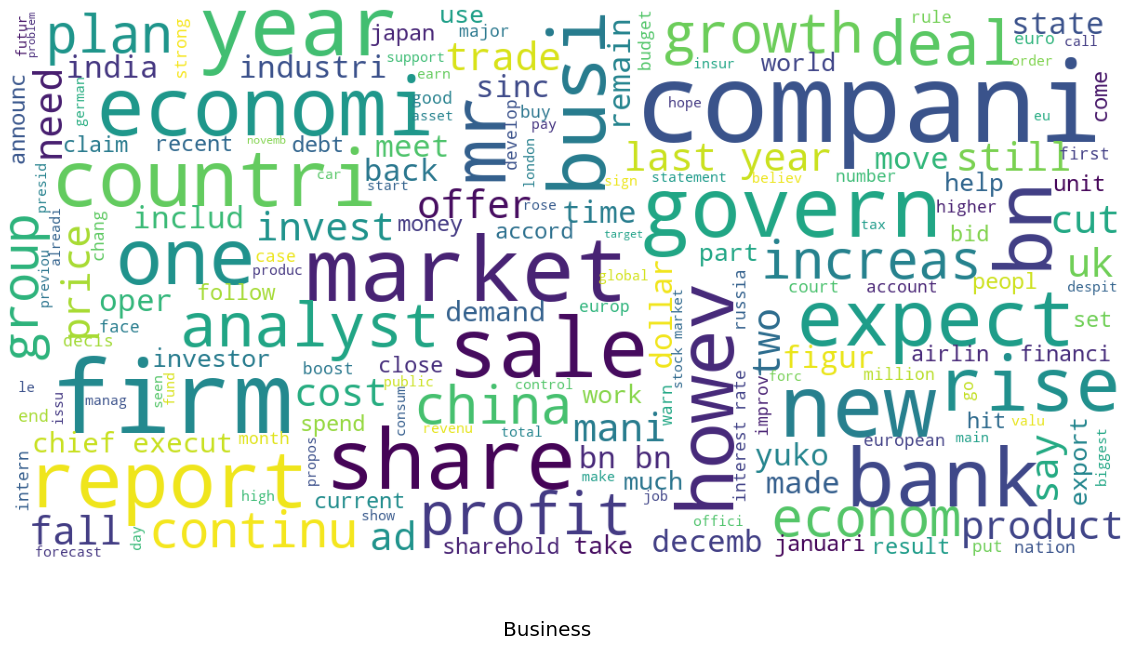

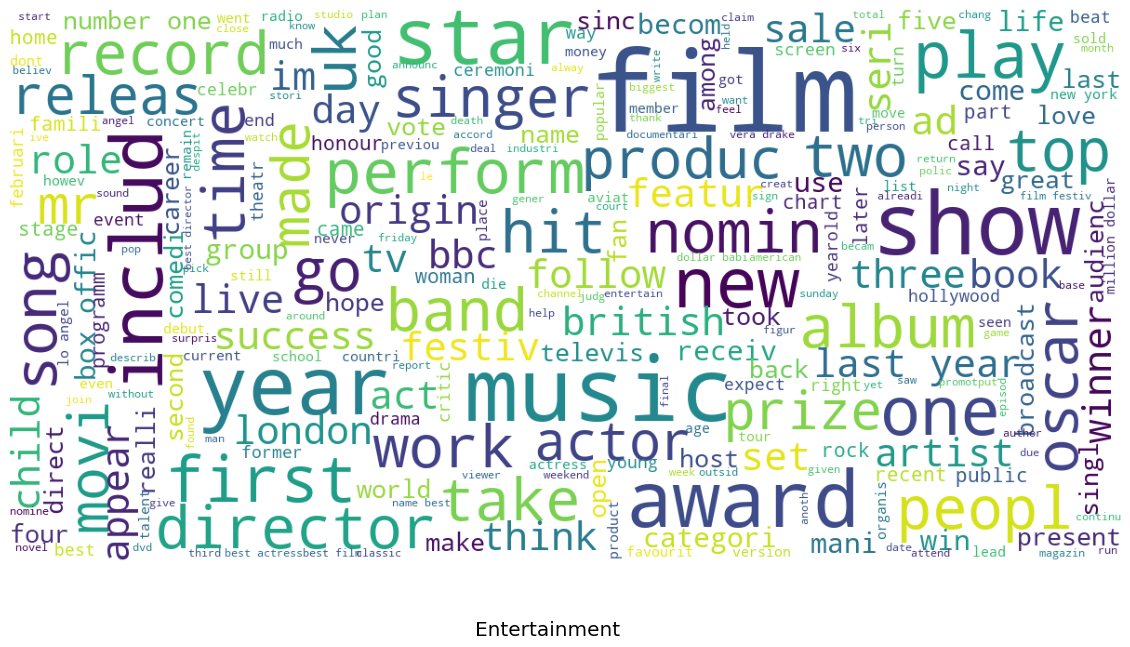

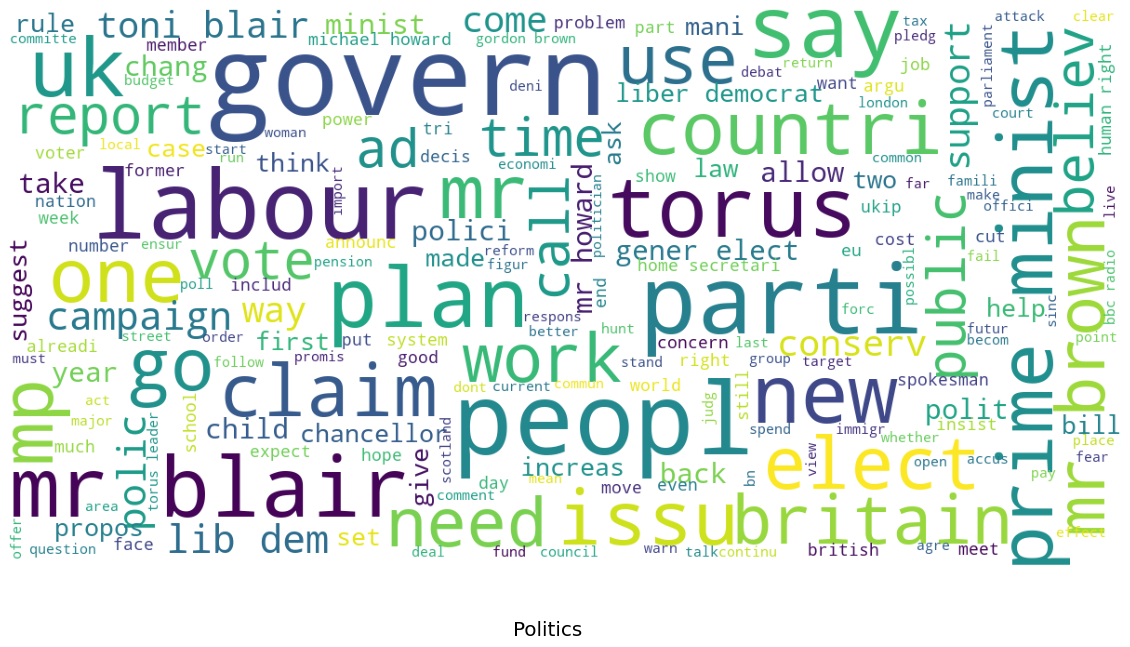

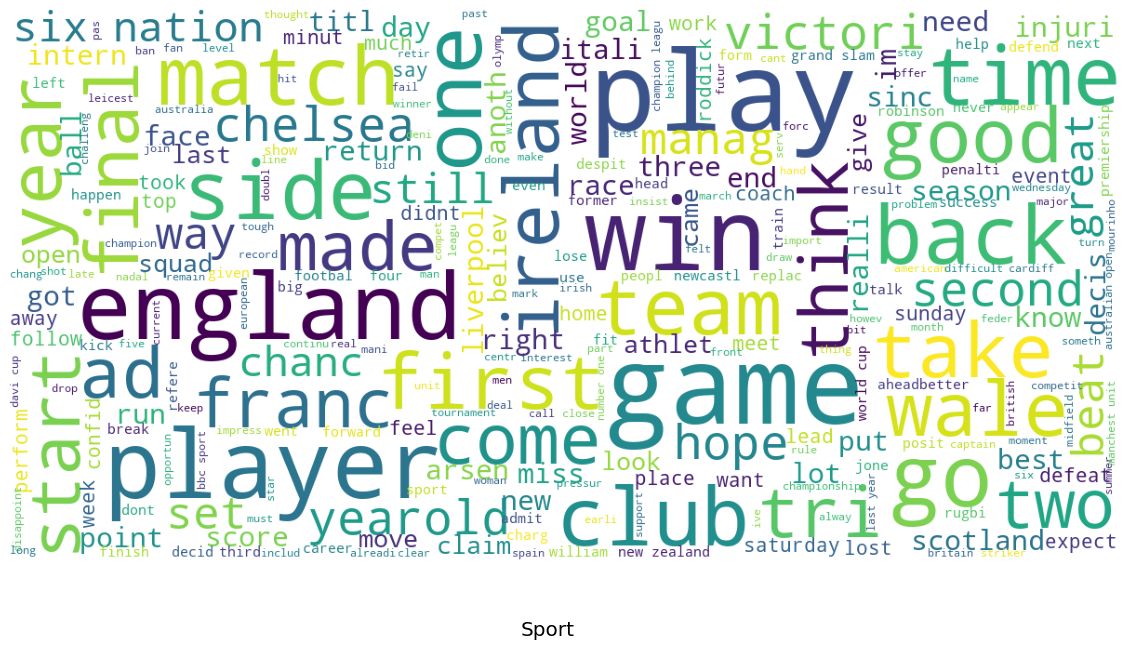

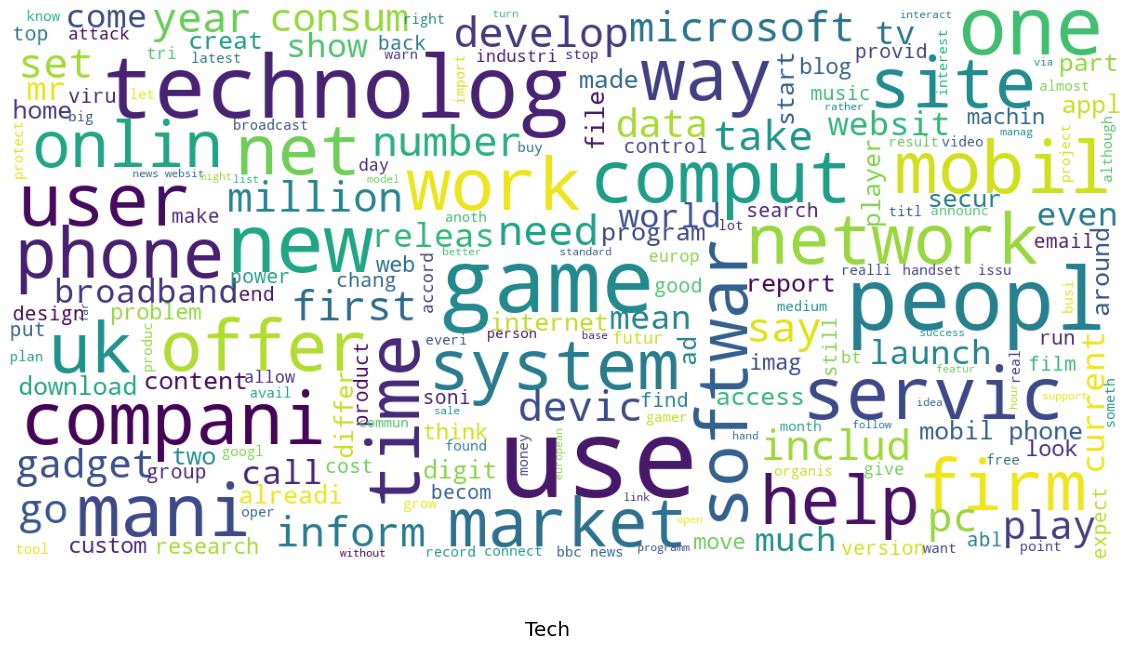

Wall time: 7.63 s


In [11]:
%%time

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# my_word_cloud: CREATES A WORDCLOUD FROM A DATAFRAME'S COLUMN
def my_word_cloud(dataframe, column_name, title = None, max_words = 1000):
    wordcloud = WordCloud(
        background_color = "white",
        max_words = max_words,
        max_font_size = 40,
        scale = 3,
        random_state = 1
    ).generate(" ".join(dataframe[column_name]))
    fig = plt.figure(1, figsize=(20,20))
    plt.axis("off")
    if title != None:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()
    
# CREATE DATAFRAMES BY CATEGORY
business = data_set.loc[data_set["category"] == "business"]
entertainment = data_set.loc[data_set["category"] == "entertainment"]
politics = data_set.loc[data_set["category"] == "politics"]
sport = data_set.loc[data_set["category"] == "sport"]
tech = data_set.loc[data_set["category"] == "tech"]
# CREATE WORDCLOUDS
my_word_cloud(business,"clean_title_and_content_stems_lemmas","Business")
my_word_cloud(entertainment,"clean_title_and_content_stems_lemmas","Entertainment")
my_word_cloud(politics,"clean_title_and_content_stems_lemmas","Politics")
my_word_cloud(sport,"clean_title_and_content_stems_lemmas","Sport")
my_word_cloud(tech,"clean_title_and_content_stems_lemmas","Tech")

## Vectorization

#### Bag Of Words

The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# calculate_bag_of_words: CALCULATES BAG OF WORDS FOR TRAIN AND TEST DATAFRAME COLUMN AND STORES THEM AS A NEW COLUMN
def calculate_bag_of_words(train_df,test_df,column):
    count_vectorizer = CountVectorizer(max_df=1.0, min_df=1, max_features=300)
    train_X_bow = count_vectorizer.fit_transform(train_df[column])
    test_X_bow = count_vectorizer.transform(test_df[column])
    
    vectors = list()
    for v in train_X_bow.toarray():
        vectors.append(v)
    # SAVE TF-IDFS AS A NEW COLUMN IN THE TRAIN DATAFRAME
    train_df[f"bow_{column}"] = pd.Series(vectors,index=train_df.index)
    
    vectors = list()
    for v in test_X_bow.toarray():
        vectors.append(v)
    # SAVE TF-IDFS AS A NEW COLUMN IN THE TEST DATAFRAME
    test_df[f"bow_{column}"] = pd.Series(vectors,index=test_df.index)

# calculate_bag_of_words_column: CALCULATES BAG OF WORDS FOR TRAIN AND TEST DATAFRAME COLUMN
def calculate_bag_of_words_column(train_df,test_df,column):
    count_vectorizer = CountVectorizer(max_df=1.0, min_df=1, max_features=300)
    train_X_bow = count_vectorizer.fit_transform(train_df[column])
    test_X_bow = count_vectorizer.transform(test_df[column])
    return train_X_bow,test_X_bow

#### Tf-idf

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# calculate_tf_idf: CALCULATES TF-IDFS FOR TRAIN AND TEST DATAFRAME COLUMN AND STORES THEM AS A NEW COLUMN
def calculate_tf_idf(train_df,test_df,column):
    tf_idf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=300)
    train_X_tf_idf = tf_idf_vectorizer.fit_transform(train_df[column])
    test_X_tf_idf = tf_idf_vectorizer.transform(test_df[column])
    
    vectors = list()
    for v in train_X_tf_idf.toarray():
        vectors.append(v)
    # SAVE TF-IDFS AS A NEW COLUMN IN THE TRAIN DATAFRAME
    train_df[f"tf_idf_{column}"] = pd.Series(vectors,index=train_df.index)
    
    vectors = list()
    for v in test_X_tf_idf.toarray():
        vectors.append(v)
    # SAVE TF-IDFS AS A NEW COLUMN IN THE TEST DATAFRAME
    test_df[f"tf_idf_{column}"] = pd.Series(vectors,index=test_df.index)

# calculate_tf_idf_column: CALCULATES TF-IDFS FOR TRAIN AND TEST DATAFRAME COLUMN
def calculate_tf_idf_column(train_df,test_df,column):
    tf_idf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=300)
    train_X_tf_idf = tf_idf_vectorizer.fit_transform(train_df[column])
    test_X_tf_idf = tf_idf_vectorizer.transform(test_df[column])
    return train_X_tf_idf,test_X_tf_idf

## Classification

#### Unify arrays

We should group all bag of words and tf-idf arrays from train and test set and calculate X_train,X_test,y_train_,y_test for each one.

In [14]:
import numpy as np

# unify_column: UNIFIES A COLUMN OF A DATAFRAME
def unify_column(dataframe,column):
    union = list()
    for index, row in dataframe.iterrows():
        union.append(dataframe.loc[index,column])
    return np.asarray(union)

#### Knn

A k-nearest-neighbor algorithm, often abbreviated k-nn, is an approach to data classification that estimates how likely a data point is to be a member of one group or the other depending on what group the data points nearest to it are in.

I used cosine_distances for the calculation of the distances between the documents. Also, I used heap for storing the distances, because i wanted to make it faster. Heap in python uses a MIN heap functionality, so I multiply the distance with -1, so I can use a max heap functionlity. Also, I keep in the heap only K elements.

In [15]:
import heapq
from heapq import heappop
from heapq import heappush
from sklearn.metrics.pairwise import cosine_distances

class knn:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X_test):
        predictions = []
        # FOR EVERY TEST SET DOCUMENT
        for x in X_test:
            # PREDICT THE CATEGORY
            category_prediction = self.__predict(x)
            # STORE THE CATEGORY WE JUST PREDICT TO PREDICTIONS LIST
            predictions.append(category_prediction)
        predictions = np.asarray(predictions)
        return predictions

    def __predict(self, X_test):
        heap = []
        heapq.heapify(heap)
        # FOR EVERY TRAIN SET DOCUMENT
        for i,x in enumerate(self.X_train):
            # CALCULATE THE DISTANCE FROM THE CURRENT TEST DOCUMENT
            distance = cosine_distances(X_test, x)
            distance = distance[0][0]
            heappush(heap, ((-1)*distance, i))
            if len(heap) > self.k:
                heappop(heap)
        # MAKE A LIST OF THE K MOST COMMON NEIGHBOURS/CATEGORIES
        most_common_categories = []
        for i in range(self.k):
            index = heappop(heap)[1]
            most_common_categories.append(self.y_train[index])
        # GET MOST COMMON CATEGORY
        most_common_category = Counter(most_common_categories).most_common(1)[0][0]
        return most_common_category

#### ROC plot

In [16]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

def roc_plot(model_name,model,train_X,train_Y,test_X,test_Y,mode):
    train_Y = label_binarize(train_Y, classes=[0, 1, 2, 3, 4])
    test_Y = label_binarize(test_Y, classes=[0, 1, 2, 3, 4])
    number_of_classes = train_Y.shape[1]

    if model_name == "knn":
        model = KNeighborsClassifier(n_neighbors=3)
    # CALCULATE SCORE
    classifier = OneVsRestClassifier(model)
    if model_name == "svm":
        score_Y = classifier.fit(train_X, train_Y).decision_function(test_X)
    else:
        score_Y = classifier.fit(train_X, train_Y).predict_proba(test_X)

    # CALCULATE ROC CURVE AND ROC AREA FOR EACH CLASS
    roc_auc = dict()
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    for i in range(number_of_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(test_Y[:, i], score_Y[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # CALCULATE MICRO AVERAGE ROC CURVE AND ROC AREA
    fpr["micro"],tpr["micro"],thresholds["micro"] = roc_curve(test_Y.ravel(), score_Y.ravel())
    roc_auc["micro"] = auc(fpr["micro"],tpr["micro"])
    
    # PLOT NEXT TO EACH OTHER
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
    # PLOT ROC CURVE
    axes[0].plot(fpr[2],tpr[2],color="indigo",lw=2,label="ROC curve (area = %0.2f)" % roc_auc[2])
    axes[0].plot([0,1],[0,1],color="navy",lw=2,linestyle="--")
    axes[0].set_xlim([0.0,1.0])
    axes[0].set_ylim([0.0,1.05])
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title(f"{model_name}_{mode}: Roc curve")
    axes[0].legend(loc="lower right")
    
    # AGGREGATE ALL FALSE POSITIVE RATES
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(number_of_classes)]))
    # INTERPOLATE ROC CURVES
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(number_of_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # CALCULATE AVERAGE AND AUC
    mean_tpr /= number_of_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    ret_roc_auc = roc_auc["macro"]

    # PLOT MULTI-CLASS ROC CURVES
    colors = cycle(["aqua","darkorange","cornflowerblue","green","grey"])
    for i, color in zip(range(number_of_classes), colors):
        axes[1].plot(fpr[i],tpr[i],color=color,lw=2,label=f"ROC curve of class {i} (area = {roc_auc[i]})")

    axes[1].plot([0,1],[0,1],"k--",lw=2)
    axes[1].set_xlim([0.0,1.0])
    axes[1].set_ylim([0.0,1.05])
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title(f"{model_name}_{mode}: Multi-class Roc curves")
    axes[1].legend(loc="lower right")

    # SAVE PLOT AS PNG
    plt.savefig(f"./report/{model_name}_{mode}_roc_curves.png")

##### Classification functions

In [17]:
import seaborn as sns
from sklearn import svm, naive_bayes
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# calculate_best_parameters: CALCULATES BEST PARAMETERS FOR A MODEL BY RUNNING GridSearchCV
def calculate_best_parameters(model,parameters,train_X,train_Y):
    clf = GridSearchCV(estimator = model, param_grid = parameters, n_jobs = -1)
    clf.fit(train_X,train_Y)
    return clf.best_params_

# run_model: RUNS A SPECIFIC CLASSIFICATION MODEL
def run_model(model_name,report,best_params,train_X,train_Y,test_X,test_Y,plot_roc_curves,mode):
    if(model_name == "svm"):
        model = svm.SVC(C=best_params["C"],kernel=best_params["kernel"],gamma=best_params["gamma"])
    elif(model_name == "rf"):
        model = RandomForestClassifier(bootstrap=best_params["bootstrap"], max_depth=best_params["max_depth"],
                                   max_features=best_params["max_features"],n_estimators=best_params["n_estimators"],
                                   min_samples_split=best_params["min_samples_split"],
                                   min_samples_leaf=best_params["min_samples_leaf"],random_state=0)
    elif(model_name == "nb"):
        model = naive_bayes.MultinomialNB()
    elif(model_name == "knn"):
        model = knn()
    
    model.fit(train_X,train_Y)
    prediction = model.predict(test_X)
    # CALCULATE STATISTICS
    report.loc[model_name,"precision"] += precision_score(prediction, test_Y,average='macro')
    report.loc[model_name,"recall"] += recall_score(prediction, test_Y,average='macro')
    report.loc[model_name,"f-measure"] += f1_score(prediction, test_Y,average='macro')
    report.loc[model_name,"accurasy"] += accuracy_score(prediction, test_Y)
    # PLOT ROC CURVES
    if plot_roc_curves is True:
        roc_plot(model_name,model,train_X,train_Y,test_X,test_Y,mode)

# execute_models: EXECUTES ALL THE MODELS AND SHOWS THE ACCURACY OF EACH ONE
def execute_models(train_X,train_Y,test_X,test_Y,mode,report,plot_roc_curves):
    # RUN GridSearchCV TO FIND BEST PARAMETERS FOR SVC
    parameters = {"kernel":("rbf","linear"),"C":[1,5,10],"gamma":("scale","auto")}
    best_params = calculate_best_parameters(svm.SVC(),parameters,train_X,train_Y)
    # RUN SVM MODEL
    run_model("svm",report,best_params,train_X,train_Y,test_X,test_Y,plot_roc_curves,mode)
    # FOUND BEST PARAMETERS FOR RF FROM GridSearchCV
    best_params={
                "bootstrap": True,
                "max_depth": 100,
                "max_features": 3,
                "min_samples_leaf": 3,
                "min_samples_split": 10,
                "n_estimators": 1000
                }
    # RUN RF MODEL
    run_model("rf",report,best_params,train_X,train_Y,test_X,test_Y,plot_roc_curves,mode)
    # RUN NB MODEL
    run_model("nb",report,best_params,train_X,train_Y,test_X,test_Y,plot_roc_curves,mode)
    # RUN KNN MODEL
    run_model("knn",report,None,train_X,train_Y,test_X,test_Y,plot_roc_curves,mode)

# classification: RUNS ALL THE CLASSIFICATION ALGORITHMS FOR BOW AND TF-IDF
def classification(train_set,test_set,column,bow_report,tf_idf_report,plot_roc_curves=False):
    # CALCULATE BAG OF WORDS FOR TRAIN AND TEST SET
    train_X_bow,test_X_bow = calculate_bag_of_words_column(train_set,test_set,column)
    # CALCULATE TF-IDFS FOR TRAIN AND TEST SET
    train_X_tf_idf,test_X_tf_idf = calculate_tf_idf_column(train_set,test_set,column)
    # CALCULATE TRAIN_Y AND TEST_Y
    train_Y = np.asarray(train_set["category_id"].tolist())
    test_Y = np.asarray(test_set["category_id"].tolist())
    
    # EXECUTE MODELS FOR BOW AND TF-IDF
    execute_models(train_X_bow,train_Y,test_X_bow,test_Y,"bow",bow_report,plot_roc_curves)
    execute_models(train_X_tf_idf,train_Y,test_X_tf_idf,test_Y,"tf_idf",tf_idf_report,plot_roc_curves)

def initialize_report():
    report = {"svm":[0,0,0,0],"rf":[0,0,0,0],"nb":[0,0,0,0],"knn":[0,0,0,0]}
    bow_report = pd.DataFrame.from_dict(report,orient="index",columns=["precision","recall","f-measure","accurasy"])
    tf_idf_report = pd.DataFrame.from_dict(report,orient="index",columns=["precision","recall","f-measure","accurasy"])
    return bow_report,tf_idf_report

def display_report(bow_report,tf_idf_report,title,save_report=False):
    display(title)
    display("----------------------------------------")
    
    display("Bow")
    display(bow_report)
    if save_report is True:
        fig = plt.figure(facecolor="w",edgecolor="k")
        sns.heatmap(bow_report,annot=True,cmap="viridis",cbar=False)
        plt.savefig(f"./report/bow_statistics.png")
    
    display("Tf-idf")
    display(tf_idf_report)
    if save_report is True:
        fig = plt.figure(facecolor="w",edgecolor="k")
        sns.heatmap(bow_report,annot=True,cmap="viridis",cbar=False)
        plt.savefig(f"./report/tf_idf_statistics.png")

##### Classification: SVM, RF, NB and KNN

In [18]:
%%time

bow_report,tf_idf_report = initialize_report()
classification(train_set,test_set,"content",bow_report,tf_idf_report)
display_report(bow_report,tf_idf_report,"content")

'content'

'----------------------------------------'

'Bow'

,precision,recall,f-measure,accurasy
svm,0.906879,0.907992,0.907341,0.912360
rf,0.900986,0.907242,0.902958,0.905618
nb,0.926781,0.925057,0.925128,0.928090
knn,0.720520,0.731260,0.714503,0.723596


'Tf-idf'

,precision,recall,f-measure,accurasy
svm,0.937134,0.935810,0.936421,0.939326
rf,0.906833,0.918678,0.911555,0.914607
nb,0.917740,0.923300,0.920133,0.923596
knn,0.875125,0.866429,0.868956,0.871910


Wall time: 15min 26s


#### 10-Fold Cross Validation

Cross-validation is any of various similar model validation techniques for assessing how the results of a statistical analysis will generalize to an independent data set.

I shuffle my data set rows because they are grouped by category and then i run 10 fold cross validation.

'content'

'----------------------------------------'

'Bow'

,precision,recall,f-measure,accurasy
svm,0.910970,0.915261,0.912195,0.914614
rf,0.905564,0.917966,0.908311,0.912835
nb,0.919046,0.920380,0.918681,0.921361
knn,0.752140,0.766363,0.749049,0.756884


'Tf-idf'

,precision,recall,f-measure,accurasy
svm,0.942108,0.943893,0.942228,0.944724
rf,0.920026,0.931136,0.922902,0.925417
nb,0.916988,0.925046,0.919203,0.921822
knn,0.868635,0.870342,0.866292,0.871482


Wall time: 1h 29min 32s


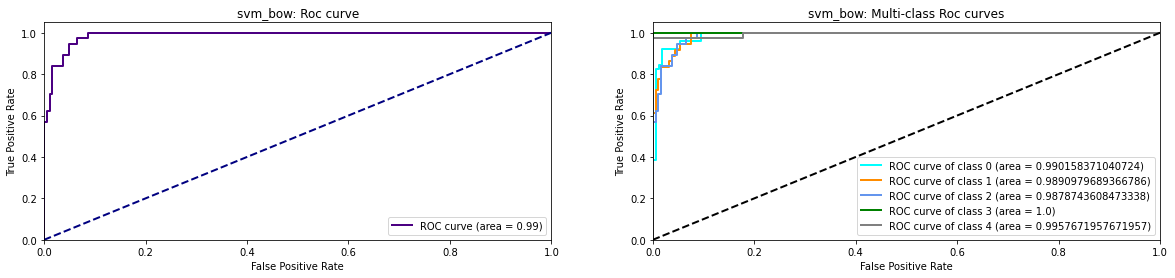

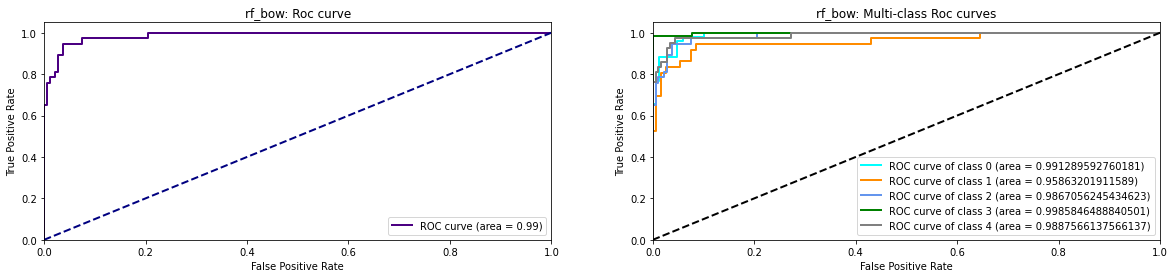

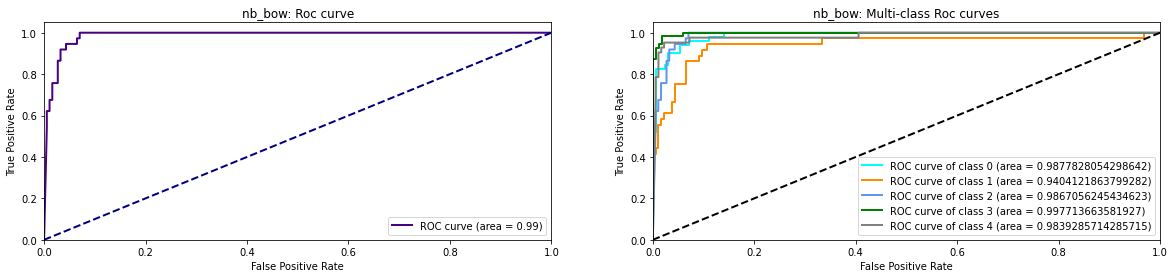

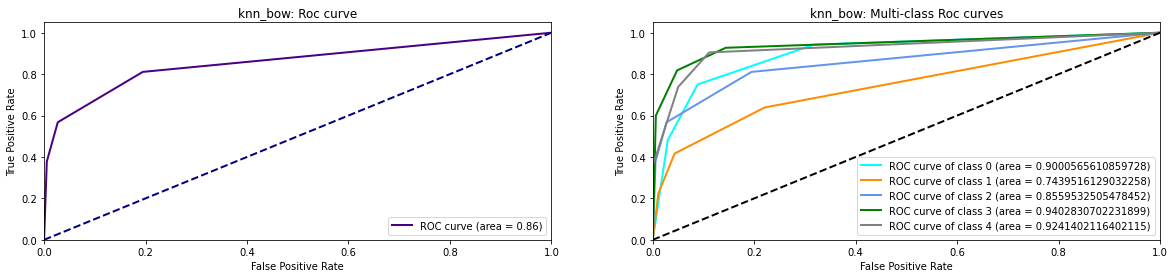

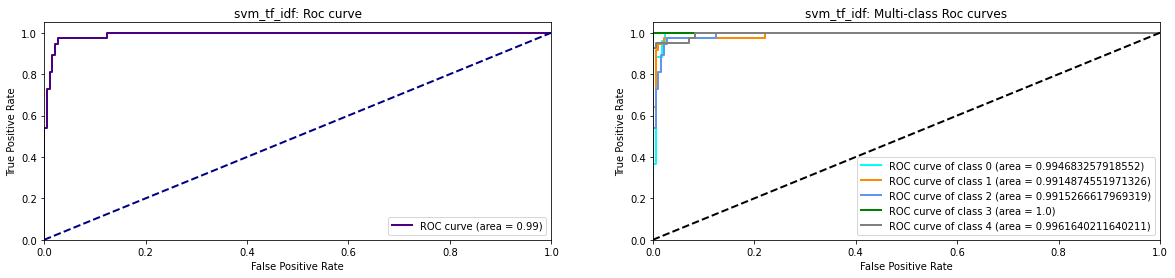

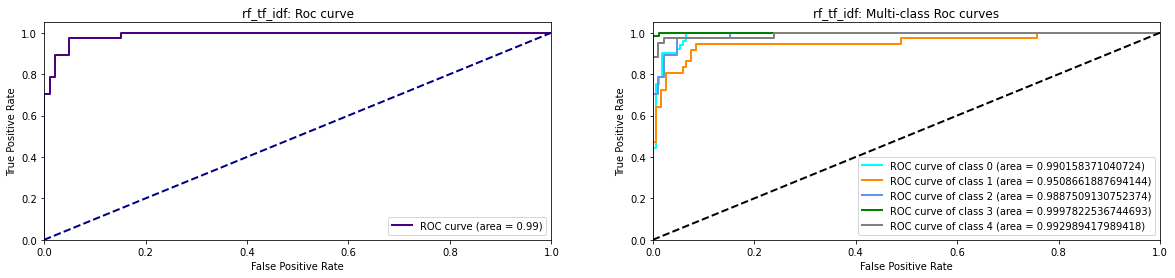

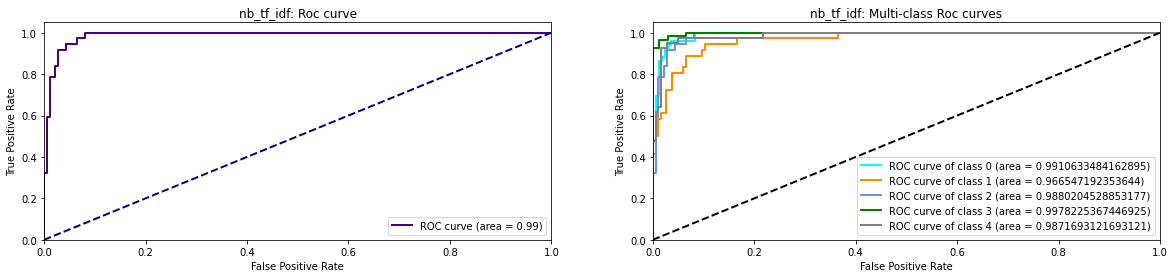

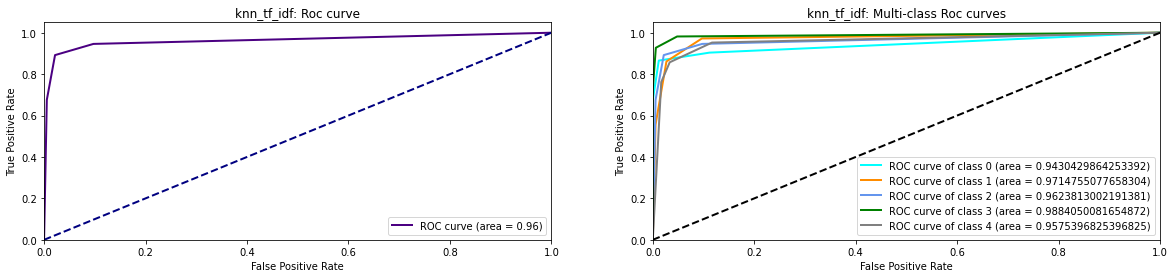

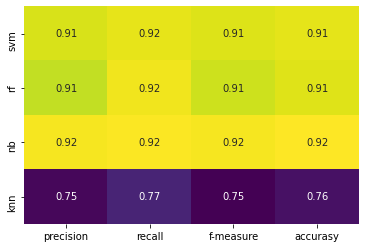

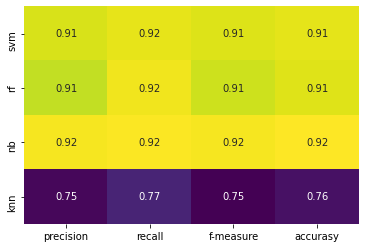

In [19]:
%%time

from sklearn.model_selection import KFold

create_directory("./report")

def k_fold_cross_validation(splits,dataframe,columns,column,roc_plot=False):
    kf = KFold(n_splits=splits)
    bow_report,tf_idf_report = initialize_report()
    for index, (train_index, test_index) in enumerate(kf.split(dataframe),start=1):
        # GET TRAIN AND TEST VALUES
        train_set_f = dataframe.iloc[train_index.tolist(),:].values
        test_set_f = dataframe.iloc[test_index.tolist(),:].values
        # CREATE TRAIN AND TEST DATAFRAMES
        train_set_f = pd.DataFrame(train_set_f,columns=columns)
        test_set_f = pd.DataFrame(test_set_f,columns=columns)
        # RUN CLASSIFICATION AND CREATE REPORT
        if ((index == splits) and (roc_plot is True)):
            classification(train_set_f,test_set_f,column,bow_report,tf_idf_report,True)
        else:
            classification(train_set_f,test_set_f,column,bow_report,tf_idf_report)

    report_columns=["precision","recall","f-measure","accurasy"]
    bow_report[report_columns] /= splits
    tf_idf_report[report_columns] /= splits
    display_report(bow_report,tf_idf_report,column,roc_plot)
    
# SHUFFLE DATASET BECAUSE IT IS GROYPED BY CATEGORY
shuffled_data_set = data_set.sample(frac=1).reset_index(drop=True)

# HIDE WARNINGS
warnings.filterwarnings("ignore")

columns = ["id","title","content","category","category_id","clean_title_and_content_stems_lemmas"]
k_fold_cross_validation(10,shuffled_data_set,columns,"content",True)

#### Beat the benchmark

Classification for cleaned, stemmed, lemmatized title concatenated with content.

In [20]:
%%time

bow_report,tf_idf_report = initialize_report()
classification(train_set,test_set,"clean_title_and_content_stems_lemmas",bow_report,tf_idf_report)
display_report(bow_report,tf_idf_report,"clean_title_and_content_stems_lemmas")

'clean_title_and_content_stems_lemmas'

'----------------------------------------'

'Bow'

,precision,recall,f-measure,accurasy
svm,0.930908,0.928022,0.929323,0.932584
rf,0.926668,0.939308,0.932054,0.934831
nb,0.924652,0.921171,0.922746,0.925843
knn,0.887009,0.886048,0.886015,0.892135


'Tf-idf'

,precision,recall,f-measure,accurasy
svm,0.937412,0.936217,0.936761,0.939326
rf,0.934908,0.944471,0.939127,0.941573
nb,0.922950,0.922120,0.922361,0.925843
knn,0.882455,0.876599,0.878558,0.883146


Wall time: 15min 17s


10-fold cross validation for cleaned, stemmed, lemmatized title concatenated with content

In [21]:
%%time

# HIDE WARNINGS
warnings.filterwarnings("ignore")

columns = ["id","title","content","category","category_id","clean_title_and_content_stems_lemmas"]
k_fold_cross_validation(10,shuffled_data_set,columns,"clean_title_and_content_stems_lemmas")

'clean_title_and_content_stems_lemmas'

'----------------------------------------'

'Bow'

,precision,recall,f-measure,accurasy
svm,0.943224,0.944307,0.943030,0.945178
rf,0.943121,0.949479,0.945119,0.946532
nb,0.942992,0.943885,0.942731,0.945172
knn,0.902580,0.903834,0.902197,0.905167


'Tf-idf'

,precision,recall,f-measure,accurasy
svm,0.962290,0.962769,0.962042,0.964051
rf,0.946414,0.951838,0.948006,0.949236
nb,0.941820,0.944149,0.942358,0.944724
knn,0.905185,0.907088,0.905261,0.908320


Wall time: 1h 29min 26s
